# Load the dataset

In [ ]:
import math
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
deliveries = pd.read_csv('/content/drive/MyDrive/Data_Mining_Datasets/match_data.csv', low_memory=False)
matches = pd.read_csv('/content/drive/MyDrive/Data_Mining_Datasets/match_info_data.csv')
df = pd.read_csv('/content/drive/MyDrive/Data_Mining_Datasets/IPL_Data.csv')

# Matches cleaning

In [ ]:
matches.columns

Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')

In [ ]:
matches.drop(columns=['season','date','dl_applied','result','win_by_runs',
       'win_by_wickets', 'player_of_match', 'city' , 'umpire1', 'umpire2',
       'umpire3'], inplace = True)
matches.head(2)

,id,team1,team2,toss_winner,toss_decision,winner,venue
0,1370353,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,field,Chennai Super Kings,"Narendra Modi Stadium, Ahmedabad"
1,1370352,Gujarat Titans,Mumbai Indians,Mumbai Indians,field,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad"


In [ ]:
matches.dropna(inplace=True)
len(matches)

1005

# Batters

In [ ]:
def preprocess_deliveries_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the deliveries DataFrame.

    This function replaces NaN values with integer 0 in specified columns,
    calculates 'total_runs' by summing up the specified columns, and restructures
    the DataFrame to a standardized format.

    Args:
        df (pd.DataFrame): The deliveries DataFrame to be preprocessed.

    Returns:
        pd.DataFrame: The preprocessed deliveries DataFrame.
    """

    # Replace NaN values with integer 0 in the specified columns
    columns_to_replace = ['runs_off_bat', 'wides', 'noballs', 'byes', 'legbyes', 'penalty']
    df[columns_to_replace] = df[columns_to_replace].fillna(0).astype(int)

    # Calculate 'total_runs' by summing up the specified columns
    df['total_runs'] = df[columns_to_replace].sum(axis=1)

    # Convert 'ball' to string and split it into 'over' and 'ball' columns
    df['ball'] = df['ball'].astype(str)
    df['over'] = df['ball'].apply(lambda x: int(x.split('.')[0]) + 1)
    df['ball'] = df['ball'].apply(lambda x: int(x.split('.')[1]))

    # Reorder the columns
    column_order = ['match_id', 'season', 'start_date', 'venue', 'innings', 'over', 'ball', 'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty', 'total_runs', 'wicket_type', 'player_dismissed', 'other_wicket_type', 'other_player_dismissed', 'cricsheet_id']

    # Reassign the DataFrame with the new column order
    df = df[column_order]

    return df

# Assuming you have a 'deliveries' DataFrame
deliveries = preprocess_deliveries_data(deliveries)

In [ ]:
def clean_team_names(data, team1_col, team2_col):
    """
    Clean team names in a DataFrame.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing team names.
    - team1_col (str): The column name for the first team.
    - team2_col (str): The column name for the second team.

    Returns:
    pd.DataFrame: The DataFrame with cleaned team names.
    """

    # Create a mapping of inconsistent team names to standardized names
    team_name_mapping = {
        'Rising Pune Supergiant': 'Rising Pune Supergiants',
        'Delhi Daredevils': 'Delhi Capitals',
        'Kings XI Punjab': 'Punjab Kings'
    }

    # Replace inconsistent team names with standardized names in team1 and team2 columns
    data[team1_col] = data[team1_col].replace(team_name_mapping)
    data[team2_col] = data[team2_col].replace(team_name_mapping)

    return data

def clean_venues(data):
    """
    Clean venue names in a DataFrame.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing venue names.

    Returns:
    pd.DataFrame: The DataFrame with cleaned venue names.
    """
    # Clean venue names by removing location information after comma (if present)
    data['venue'] = data['venue'].str.split(',').str[0]

    # Rename specific venues
    venue_rename_mapping = {
        'Sardar Patel Stadium': 'Narendra Modi Stadium',
        'Feroz Shah Kotla': 'Arun Jaitley Stadium'
    }
    data['venue'] = data['venue'].replace(venue_rename_mapping)

    return data

def clean_data(deliveries, matches):
    """
    Clean team names and venue names in DataFrames.

    Parameters:
    - deliveries (pd.DataFrame): The DataFrame containing delivery data.
    - matches (pd.DataFrame): The DataFrame containing match data.

    Returns:
    pd.DataFrame, pd.DataFrame: Cleaned delivery and match DataFrames.
    """
    # Clean team names in deliveries and matches DataFrames
    deliveries = clean_team_names(deliveries, 'batting_team', 'bowling_team')
    matches = clean_team_names(matches, 'team1','team2')
    matches = clean_team_names(matches, 'toss_winner','winner')

    # Clean venues in deliveries and matches DataFrames
    deliveries = clean_venues(deliveries)
    matches = clean_venues(matches)

    return deliveries,matches
# Call the function to clean the data
deliveries, matches = clean_data(deliveries, matches)

print(deliveries.head(2))

   match_id season  start_date                  venue  innings  over  ball  \
0   1370353   2023  2023-05-29  Narendra Modi Stadium        1     1     1   
1   1370353   2023  2023-05-29  Narendra Modi Stadium        1     1     2   

     batting_team         bowling_team  striker  ... noballs byes  legbyes  \
0  Gujarat Titans  Chennai Super Kings  WP Saha  ...       0    0        0   
1  Gujarat Titans  Chennai Super Kings  WP Saha  ...       0    0        0   

   penalty  total_runs  wicket_type  player_dismissed  other_wicket_type  \
0        0           0          NaN               NaN                NaN   
1        0           0          NaN               NaN                NaN   

   other_player_dismissed  cricsheet_id  
0                     NaN       1370353  
1                     NaN       1370353  

[2 rows x 25 columns]


In [ ]:
matches

,id,team1,team2,toss_winner,toss_decision,winner,venue
0,1370353,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,field,Chennai Super Kings,Narendra Modi Stadium
1,1370352,Gujarat Titans,Mumbai Indians,Mumbai Indians,field,Gujarat Titans,Narendra Modi Stadium
2,1370351,Mumbai Indians,Lucknow Super Giants,Mumbai Indians,bat,Mumbai Indians,MA Chidambaram Stadium
3,1370350,Chennai Super Kings,Gujarat Titans,Gujarat Titans,field,Chennai Super Kings,MA Chidambaram Stadium
4,1359543,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,Mumbai Indians,Wankhede Stadium
...,...,...,...,...,...,...,...
1019,335986,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,Eden Gardens
1020,335985,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,Wankhede Stadium
1021,335984,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,Arun Jaitley Stadium
1022,335983,Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,Punjab Cricket Association Stadium


In [ ]:
import pandas as pd

# Assuming 'deliveries' is your DataFrame with the provided columns

# Grouping the DataFrame by match ID and inning
grouped = deliveries.groupby(['match_id', 'innings'])

# Dictionary to store batting positions
batting_order = {}

# Iterate through the grouped DataFrame
for name, group in grouped:
    # Initialize a dictionary to store batting positions for the current inning
    inning_batting_order = {}

    # Iterate through each row in the group
    for index, row in group.iterrows():
        striker = row['striker']

        # Check if the striker is already in the batting order dictionary
        if striker not in inning_batting_order:
            # Assign the batting position to the striker
            inning_batting_order[striker] = len(inning_batting_order) + 1

    # Combine the inning batting order with the overall batting order
    for player, position in inning_batting_order.items():
        if player not in batting_order:
            batting_order[player] = position



In [ ]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1

def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1

def calculate_player_statistics(df, criteria=None):
    """
    Calculate various batting statistics for each player.

    Args:
        df (pd.DataFrame): The DataFrame containing delivery data.
        criteria (dict, optional): A dictionary specifying a filter criteria, e.g., {'column': 'season', 'value': 2023}.

    Returns:
        pd.DataFrame: The DataFrame with player-level statistics.

    Calculates the following player-level statistics:
    - Strike Rate (SR): Measures a player's ability to score quickly.
    - Runs per Inning (RPI): Indicates a player's average runs per inning.
    - Balls per Dismissal (BPD): Shows how often a player gets dismissed.
    - Balls per Boundary (BPB): Measures a player's boundary-hitting ability.
    """

    # Calculate dot balls, ones, twos, threes, fours, and sixes
    df['isDot'] = (df['runs_off_bat'] == 0).astype(int)
    df['isOne'] = (df['runs_off_bat'] == 1).astype(int)
    df['isTwo'] = (df['runs_off_bat'] == 2).astype(int)
    df['isThree'] = (df['runs_off_bat'] == 3).astype(int)
    df['isFour'] = (df['runs_off_bat'] == 4).astype(int)
    df['isSix'] = (df['runs_off_bat'] == 6).astype(int)

    # Calculate runs, innings, balls, dismissals, and other statistics
    runs = pd.DataFrame(df.groupby(['striker'])['runs_off_bat'].sum().reset_index()).groupby(['striker'])['runs_off_bat'].sum().reset_index().rename(columns={'runs_off_bat':'runs'})
    innings = pd.DataFrame(df.groupby(['striker'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns={'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['striker'])['match_id'].count()).reset_index().rename(columns={'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['striker'])['player_dismissed'].count()).reset_index().rename(columns={'player_dismissed':'dismissals'})

    dots = pd.DataFrame(df.groupby(['striker'])['isDot'].sum()).reset_index().rename(columns={'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['striker'])['isOne'].sum()).reset_index().rename(columns={'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['striker'])['isTwo'].sum()).reset_index().rename(columns={'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['striker'])['isThree'].sum()).reset_index().rename(columns={'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['striker'])['isFour'].sum()).reset_index().rename(columns={'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['striker'])['isSix'].sum()).reset_index().rename(columns={'isSix':'sixes'})

    df = pd.merge(innings, runs, on='striker').merge(balls, on='striker').merge(dismissals, on='striker').merge(dots, on='striker').merge(ones, on='striker').merge(twos, on='striker').merge(threes, on='striker').merge(fours, on='striker').merge(sixes, on='striker')

    # Calculate Strike Rate (SR)
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis=1)

    # Calculate Runs per Inning (RPI)
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis=1)

    # Calculate Balls per Dismissal (BPD)
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis=1)

    # Calculate Balls per Boundary (BPB)
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis=1)

    return df

In [ ]:
# Calculate player statistics from delivery data
player_stats_df = calculate_player_statistics(deliveries)



In [ ]:
# Iterate over each row in player_stats_df
for index, row in player_stats_df.iterrows():
    player = row['striker']
    if player in batting_order:
        position = batting_order[player]
        player_stats_df.at[index, 'position'] = position

player_stats_df.rename(columns ={'SR':'BattingSR'} )


,striker,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,BattingSR,RPI,BPD,BPB,position
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581,8.0
1,A Badoni,23,399,325,18,127,124,28,3,24,19,122.769231,17.347826,18.055556,7.558140,6.0
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000,9.0
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286,1.0
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Yashpal Singh,4,47,67,4,39,20,2,1,5,0,70.149254,11.750000,16.750000,13.400000,7.0
633,Younis Khan,1,3,7,1,4,3,0,0,0,0,42.857143,3.000000,7.000000,7.000000,3.0
634,Yudhvir Singh,2,1,2,2,1,1,0,0,0,0,50.000000,0.500000,1.000000,2.000000,9.0
635,Yuvraj Singh,126,2754,2207,109,977,741,119,3,218,149,124.784776,21.857143,20.247706,6.013624,4.0


In [ ]:
# Display the first few rows of the player statistics DataFrame
player_stats_df.to_csv('player_data.csv')
player_stats_df

,striker,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,position
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581,8.0
1,A Badoni,23,399,325,18,127,124,28,3,24,19,122.769231,17.347826,18.055556,7.558140,6.0
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000,9.0
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286,1.0
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Yashpal Singh,4,47,67,4,39,20,2,1,5,0,70.149254,11.750000,16.750000,13.400000,7.0
633,Younis Khan,1,3,7,1,4,3,0,0,0,0,42.857143,3.000000,7.000000,7.000000,3.0
634,Yudhvir Singh,2,1,2,2,1,1,0,0,0,0,50.000000,0.500000,1.000000,2.000000,9.0
635,Yuvraj Singh,126,2754,2207,109,977,741,119,3,218,149,124.784776,21.857143,20.247706,6.013624,4.0


# Bowlers

In [ ]:
deliveries.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'over', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'total_runs', 'wicket_type', 'player_dismissed',
       'other_wicket_type', 'other_player_dismissed', 'cricsheet_id', 'isDot',
       'isOne', 'isTwo', 'isThree', 'isFour', 'isSix'],
      dtype='object')

In [ ]:
player_stats_df.columns

Index(['striker', 'innings', 'runs', 'balls', 'dismissals', 'dots', 'ones',
       'twos', 'threes', 'fours', 'sixes', 'SR', 'RPI', 'BPD', 'BPB',
       'position'],
      dtype='object')

In [ ]:
df = deliveries.copy()

In [ ]:
import pandas as pd

# Assume you have a dataframe 'df' with the given columns
bowling_stats = (
    df
    .groupby(['bowling_team', 'bowler'])
    .agg({
        'ball': 'sum',
        'runs_off_bat': 'sum',
        'extras': 'sum',
        'wides': 'sum',
        'noballs': 'sum',
        'byes': 'sum',
        'legbyes': 'sum',
        'penalty': 'sum',
        'total_runs': 'sum',
        'wicket_type': 'count'
    })
    .reset_index()
)

# Rename the columns to more descriptive names
bowling_stats.columns = [
    'bowling_team',
    'bowler',
    'balls',
    'runs_conceded',
    'extras',
    'wides',
    'noballs',
    'byes',
    'legbyes',
    'penalty_runs',
    'total_runs',
    'wickets'
]

# Calculate additional metrics
bowling_stats['overs'] = (bowling_stats['balls'] / 6 ).astype(int)
bowling_stats['economy_rate'] = bowling_stats['total_runs'] / bowling_stats['overs']
bowling_stats['strike_rate'] = bowling_stats['balls'] / bowling_stats['wickets']

# Sort the dataframe by a relevant metric (e.g., wickets)
bowling_stats = bowling_stats.sort_values('wickets', ascending=False)

In [ ]:
import numpy as np

# Assuming you have the 'bowling_stats' dataframe
bowling_stats.loc[bowling_stats['overs'] == np.inf, 'overs'] = 0
bowling_stats.loc[bowling_stats['economy_rate'] == np.inf, 'economy_rate'] = 0
bowling_stats.loc[bowling_stats['strike_rate'] == np.inf, 'strike_rate'] = 0
bowling_stats = bowling_stats.drop(columns=['bowling_team'], inplace=False)

In [ ]:
bowling_stats.drop_duplicates()

,bowler,balls,runs_conceded,extras,wides,noballs,byes,legbyes,penalty_runs,total_runs,wickets,overs,economy_rate,strike_rate
468,SL Malinga,10895,3194,292,152,20,28,87,5,3486,188,1815,1.920661,57.952128
344,SP Narine,13545,4129,167,81,4,16,66,0,4296,182,2257,1.903412,74.423077
422,JJ Bumrah,10314,3298,201,79,30,13,79,0,3499,161,1719,2.035486,64.062112
858,B Kumar,10994,3545,209,124,8,8,69,0,3754,159,1832,2.049127,69.144654
14,DJ Bravo,8832,3006,193,134,7,2,50,0,3199,158,1472,2.173234,55.898734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,S Badree,91,33,2,1,0,0,1,0,35,0,15,2.333333,0.000000
501,M Manhas,147,42,0,0,0,0,0,0,42,0,24,1.750000,0.000000
505,NL McCullum,105,34,1,0,0,0,1,0,35,0,17,2.058824,0.000000
247,J Yadav,84,26,0,0,0,0,0,0,26,0,14,1.857143,0.000000


In [ ]:
player_stats_df.rename(columns={'SR' : 'BowlingSR'})

,striker,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,BowlingSR,RPI,BPD,BPB,position
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581,8.0
1,A Badoni,23,399,325,18,127,124,28,3,24,19,122.769231,17.347826,18.055556,7.558140,6.0
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000,9.0
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286,1.0
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Yashpal Singh,4,47,67,4,39,20,2,1,5,0,70.149254,11.750000,16.750000,13.400000,7.0
633,Younis Khan,1,3,7,1,4,3,0,0,0,0,42.857143,3.000000,7.000000,7.000000,3.0
634,Yudhvir Singh,2,1,2,2,1,1,0,0,0,0,50.000000,0.500000,1.000000,2.000000,9.0
635,Yuvraj Singh,126,2754,2207,109,977,741,119,3,218,149,124.784776,21.857143,20.247706,6.013624,4.0


In [ ]:
max(bowling_stats['economy_rate'])

8.333333333333334

# Merge DataFrames

In [ ]:
batting_stats = player_stats_df.copy()

In [ ]:
len(batting_stats['striker'].unique())

637

In [ ]:
import pandas as pd

# Assuming you have two dataframes, 'bowling_stats' and 'batting_stats'
# with the respective column names

# Concatenate the 'bowler' and 'striker' columns into a single 'player' column
all_players = bowling_stats['bowler'].unique().tolist() + batting_stats['striker'].unique().tolist()
all_players = list(set(all_players))
print(len(all_players))

consolidated_df = pd.DataFrame({'player': all_players})

# Populate the batting statistics
for player in all_players:
    batting_mask = batting_stats['striker'] == player
    consolidated_df.loc[consolidated_df['player'] == player, 'innings'] = batting_stats.loc[batting_mask, 'innings'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'runs'] = batting_stats.loc[batting_mask, 'runs'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'ball_played'] = batting_stats.loc[batting_mask, 'balls'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'dismissals'] = batting_stats.loc[batting_mask, 'dismissals'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'dots'] = batting_stats.loc[batting_mask, 'dots'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'ones'] = batting_stats.loc[batting_mask, 'ones'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'twos'] = batting_stats.loc[batting_mask, 'twos'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'threes'] = batting_stats.loc[batting_mask, 'threes'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'fours'] = batting_stats.loc[batting_mask, 'fours'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'sixes'] = batting_stats.loc[batting_mask, 'sixes'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'SR'] = batting_stats.loc[batting_mask, 'SR'].mean()
    consolidated_df.loc[consolidated_df['player'] == player, 'RPI'] = batting_stats.loc[batting_mask, 'RPI'].mean()
    consolidated_df.loc[consolidated_df['player'] == player, 'BPD'] = batting_stats.loc[batting_mask, 'BPD'].mean()
    consolidated_df.loc[consolidated_df['player'] == player, 'BPB'] = batting_stats.loc[batting_mask, 'BPB'].mean()
    consolidated_df.loc[consolidated_df['player'] == player, 'position'] = batting_stats.loc[batting_mask, 'position'].mean()

# Populate the bowling statistics
for player in all_players:
    bowling_mask = bowling_stats['bowler'] == player
    consolidated_df.loc[consolidated_df['player'] == player, 'balls_thrown'] = bowling_stats.loc[bowling_mask, 'balls'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'runs_conceded'] = bowling_stats.loc[bowling_mask, 'runs_conceded'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'extras'] = bowling_stats.loc[bowling_mask, 'extras'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'wides'] = bowling_stats.loc[bowling_mask, 'wides'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'noballs'] = bowling_stats.loc[bowling_mask, 'noballs'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'byes'] = bowling_stats.loc[bowling_mask, 'byes'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'legbyes'] = bowling_stats.loc[bowling_mask, 'legbyes'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'penalty_runs'] = bowling_stats.loc[bowling_mask, 'penalty_runs'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'total_runs'] = bowling_stats.loc[bowling_mask, 'total_runs'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'wickets'] = bowling_stats.loc[bowling_mask, 'wickets'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'overs'] = bowling_stats.loc[bowling_mask, 'overs'].sum()
    consolidated_df.loc[consolidated_df['player'] == player, 'economy_rate'] = (bowling_stats.loc[bowling_mask, 'total_runs'].sum() / bowling_stats.loc[bowling_mask, 'overs'].sum())
    consolidated_df.loc[consolidated_df['player'] == player, 'strike_rate'] = (bowling_stats.loc[bowling_mask, 'balls'].sum() / bowling_stats.loc[bowling_mask, 'wickets'].sum())

694


<ipython-input-25-33398b8d646c>:46: RuntimeWarning: invalid value encountered in scalar divide
  consolidated_df.loc[consolidated_df['player'] == player, 'economy_rate'] = (bowling_stats.loc[bowling_mask, 'total_runs'].sum() / bowling_stats.loc[bowling_mask, 'overs'].sum())
<ipython-input-25-33398b8d646c>:47: RuntimeWarning: invalid value encountered in scalar divide
  consolidated_df.loc[consolidated_df['player'] == player, 'strike_rate'] = (bowling_stats.loc[bowling_mask, 'balls'].sum() / bowling_stats.loc[bowling_mask, 'wickets'].sum())
<ipython-input-25-33398b8d646c>:47: RuntimeWarning: divide by zero encountered in scalar divide
  consolidated_df.loc[consolidated_df['player'] == player, 'strike_rate'] = (bowling_stats.loc[bowling_mask, 'balls'].sum() / bowling_stats.loc[bowling_mask, 'wickets'].sum())
<ipython-input-25-33398b8d646c>:46: RuntimeWarning: divide by zero encountered in scalar divide
  consolidated_df.loc[consolidated_df['player'] == player, 'economy_rate'] = (bowling_

In [ ]:
consolidated_df.fillna(0, inplace = True)

In [ ]:
consolidated_df
consolidated_df[['player', 'position']]

,player,position
0,A Nortje,9.0
1,H Das,7.0
2,HH Gibbs,3.0
3,TA Boult,10.0
4,NB Singh,0.0
...,...,...
689,Mandeep Singh,3.0
690,BJ Haddin,2.0
691,Bipul Sharma,9.0
692,JPR Scantlebury-Searles,8.0


In [ ]:
consolidated_df.columns

Index(['player', 'innings', 'runs', 'ball_played', 'dismissals', 'dots',
       'ones', 'twos', 'threes', 'fours', 'sixes', 'SR', 'RPI', 'BPD', 'BPB',
       'position', 'balls_thrown', 'runs_conceded', 'extras', 'wides',
       'noballs', 'byes', 'legbyes', 'penalty_runs', 'total_runs', 'wickets',
       'overs', 'economy_rate', 'strike_rate'],
      dtype='object')

In [ ]:
consolidated_df.to_csv('final_ipl_data.csv')

# Visualisation

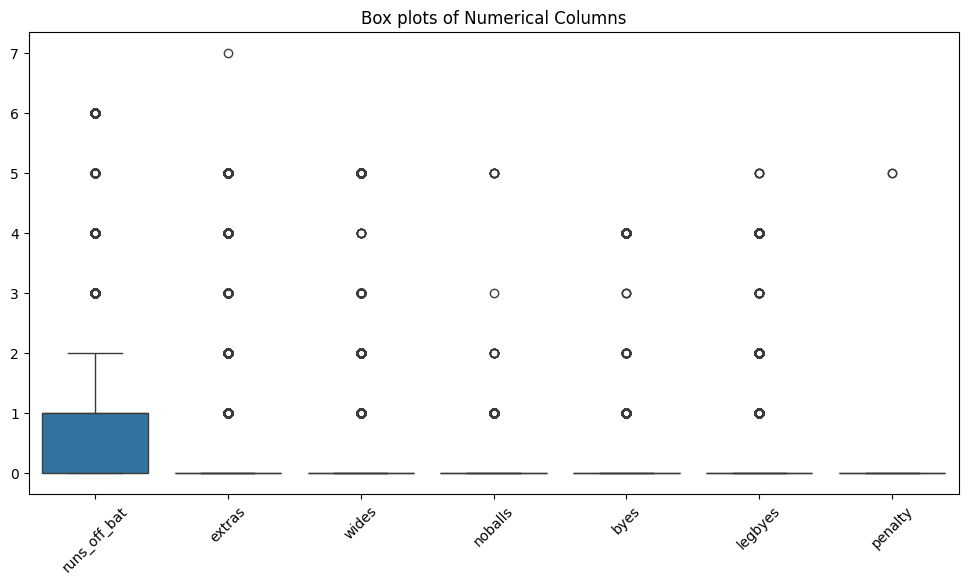

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame containing numerical columns
# Replace df with your actual DataFrame name

# Assuming numerical_columns is a list of numerical column names
numerical_columns = ['runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty']

# Plot box plots for numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=deliveries[numerical_columns])
plt.title("Box plots of Numerical Columns")
plt.xticks(rotation=45)
plt.show()


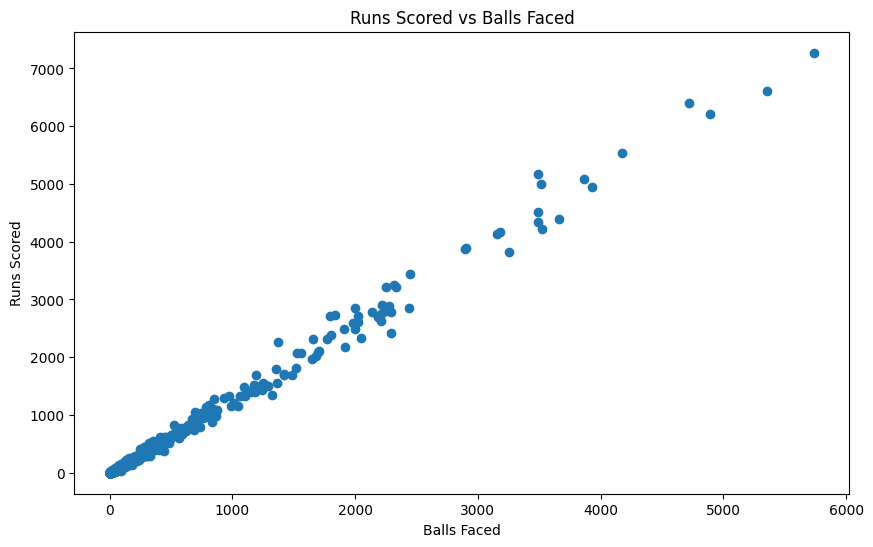

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(consolidated_df['ball_played'], consolidated_df['runs'])
plt.xlabel('Balls Faced')
plt.ylabel('Runs Scored')
plt.title('Runs Scored vs Balls Faced')
plt.show()

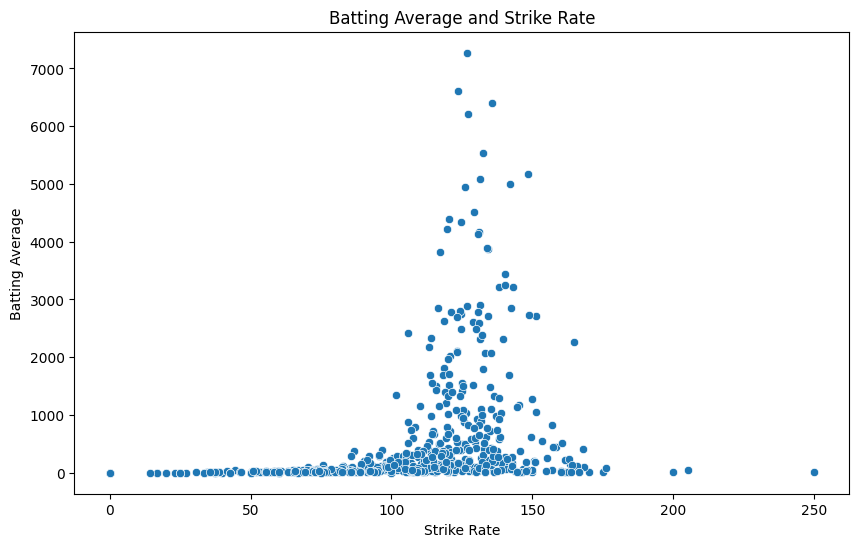

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='SR', y='runs', data=consolidated_df)
plt.xlabel('Strike Rate')
plt.ylabel('Batting Average')
plt.title('Batting Average and Strike Rate')
plt.show()

In [ ]:
consolidated_df.columns

Index(['player', 'innings', 'runs', 'ball_played', 'dismissals', 'dots',
       'ones', 'twos', 'threes', 'fours', 'sixes', 'SR', 'RPI', 'BPD', 'BPB',
       'position', 'balls_thrown', 'runs_conceded', 'extras', 'wides',
       'noballs', 'byes', 'legbyes', 'penalty_runs', 'total_runs', 'wickets',
       'overs', 'economy_rate', 'strike_rate'],
      dtype='object')

In [ ]:
# Calculate batting average
consolidated_df['batting_avg'] = consolidated_df['runs'] / consolidated_df['dismissals']
consolidated_df['batting_avg'] = consolidated_df['batting_avg'].fillna(0)  # Replace NaNs with 0

# Calculate bowling average
consolidated_df['bowling_avg'] = consolidated_df['runs_conceded'] / consolidated_df['wickets']
consolidated_df['bowling_avg'] = consolidated_df['bowling_avg'].fillna(0)  # Replace NaNs with 0

consolidated_df.fillna(0,inplace = True)

In [ ]:
consolidated_df.loc[consolidated_df['economy_rate'] == np.inf, 'economy_rate'] = 0
consolidated_df.loc[consolidated_df['strike_rate'] == np.inf, 'strike_rate'] = 0

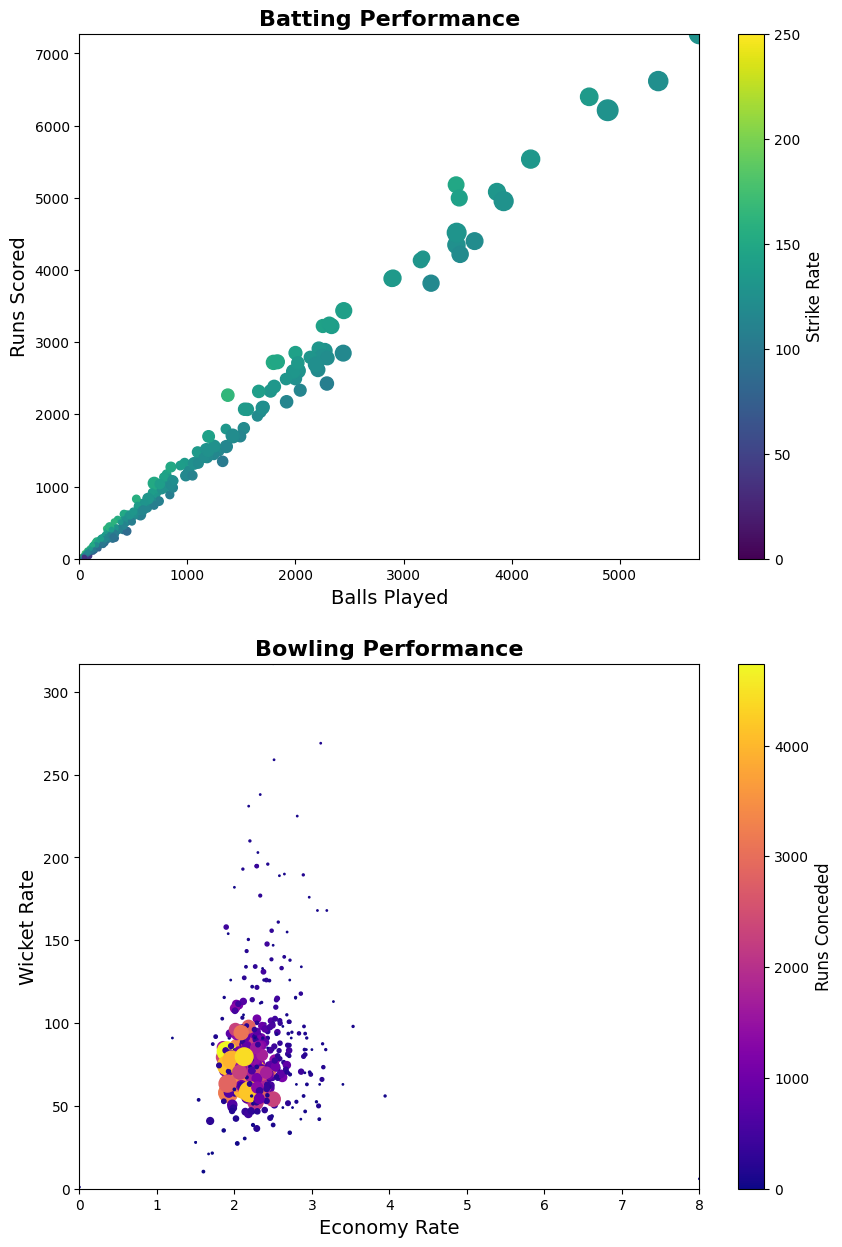

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Batting Performance
ax1.set_title('Batting Performance', fontsize=16, fontweight='bold')
scatter = ax1.scatter(x='ball_played', y='runs', s='dismissals', c='SR', cmap='viridis', data=consolidated_df)
ax1.set_xlabel('Balls Played', fontsize=14)
ax1.set_ylabel('Runs Scored', fontsize=14)
ax1.set_xlim(0, consolidated_df['ball_played'].max())
ax1.set_ylim(0, consolidated_df['runs'].max())
cbar = fig.colorbar(scatter, ax=ax1)
cbar.set_label('Strike Rate', fontsize=12)

# Bowling Performance
ax2.set_title('Bowling Performance', fontsize=16, fontweight='bold')
scatter = ax2.scatter(x='economy_rate', y='strike_rate', s='wickets', c='runs_conceded', cmap='plasma', data=consolidated_df)
ax2.set_xlabel('Economy Rate', fontsize=14)
ax2.set_ylabel('Wicket Rate', fontsize=14)
ax2.set_xlim(0, consolidated_df['economy_rate'].max())
ax2.set_ylim(0, consolidated_df['strike_rate'].max())
cbar = fig.colorbar(scatter, ax=ax2)
cbar.set_label('Runs Conceded', fontsize=12)

plt.show()

Scatter Plot of Run Per Innings vs Ball Per Dismissals

*   List item
*   List item



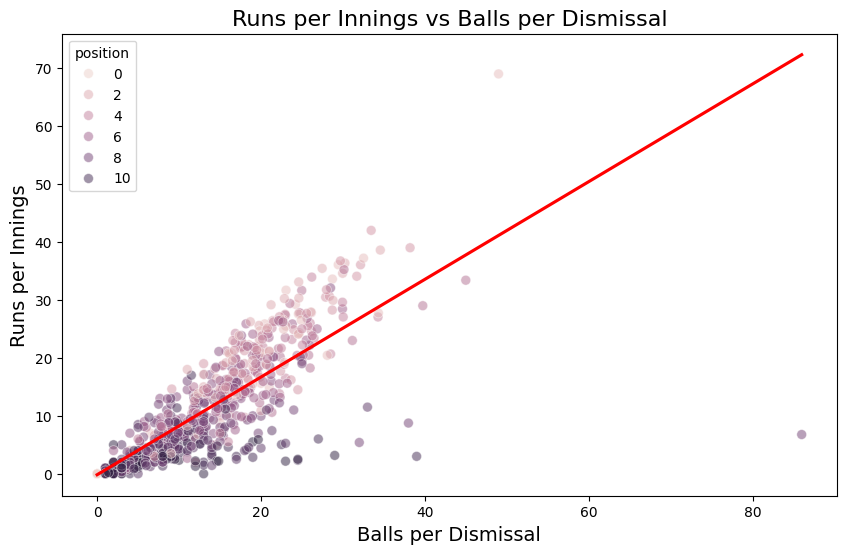

In [ ]:
import numpy as np

plt.figure(figsize=(10, 6))
sns.scatterplot(data=consolidated_df, x='BPD', y='RPI', hue='position', alpha=0.5, s=50)
sns.regplot(data=consolidated_df, x='BPD', y='RPI', scatter=False, order=1, ci=None, color='r')
plt.title('Runs per Innings vs Balls per Dismissal', fontsize=16)
plt.xlabel('Balls per Dismissal', fontsize=14)
plt.ylabel('Runs per Innings', fontsize=14)
plt.show()

runs_conceded vs balls_thrown

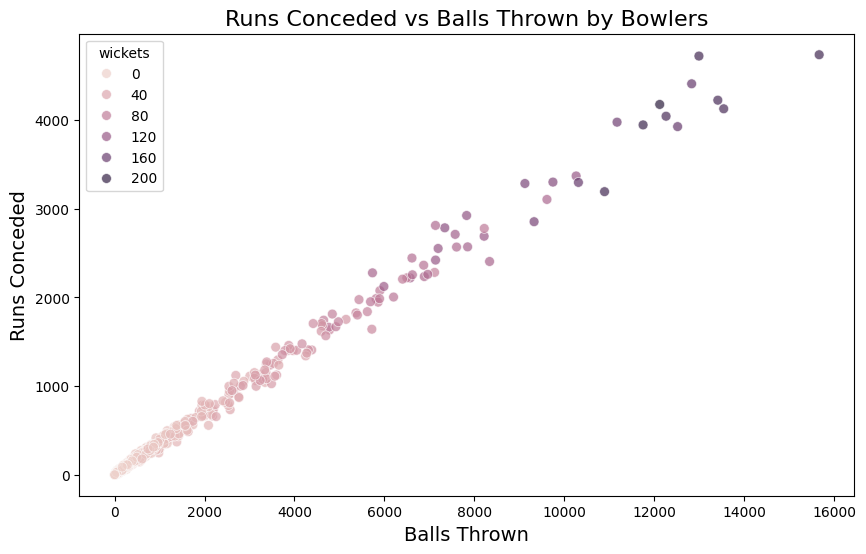

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of runs_conceded vs balls_thrown, colored by wickets
plt.figure(figsize=(10, 6))
sns.scatterplot(data=consolidated_df, x='balls_thrown', y='runs_conceded', hue='wickets', s=50, alpha=0.7)
plt.title('Runs Conceded vs Balls Thrown by Bowlers', fontsize=16)
plt.xlabel('Balls Thrown', fontsize=14)
plt.ylabel('Runs Conceded', fontsize=14)
plt.show()



Strike Rate vs. Balls Played

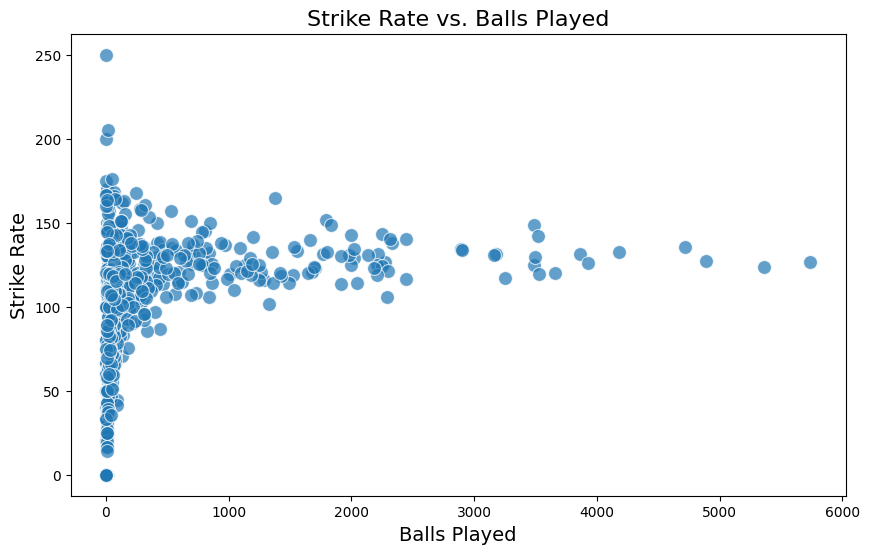

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(data=consolidated_df, x='ball_played', y='SR', s=100, alpha=0.7, ax=ax)

# Add labels and title
ax.set_xlabel('Balls Played', fontsize=14)
ax.set_ylabel('Strike Rate', fontsize=14)
ax.set_title('Strike Rate vs. Balls Played', fontsize=16)

# Show the plot
plt.show()

Economy Rate Distribution: Histogram showing the distribution of economy rates of bowlers.

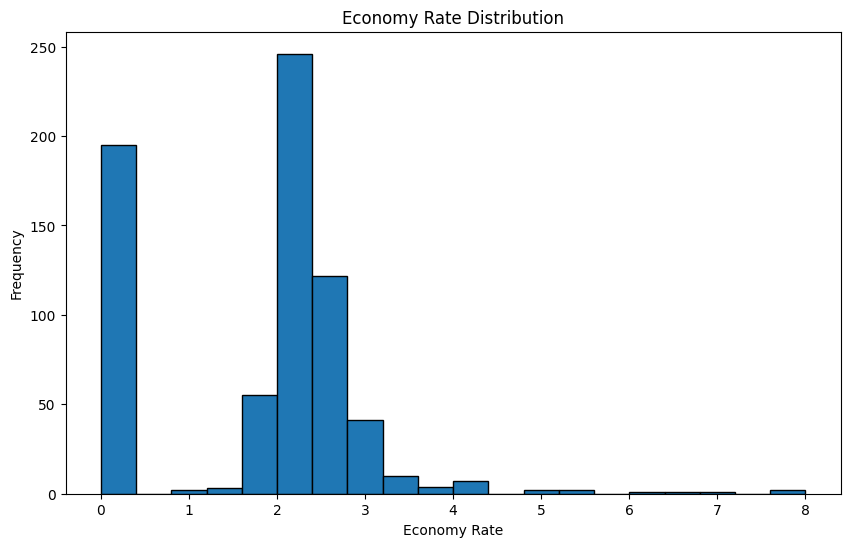

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is in a pandas DataFrame named 'df'
economy_rates = consolidated_df['economy_rate']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(economy_rates, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Economy Rate')
plt.ylabel('Frequency')
plt.title('Economy Rate Distribution')

# Show the plot
plt.show()

In [ ]:
matches.columns

Index(['id', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'venue'],
      dtype='object')

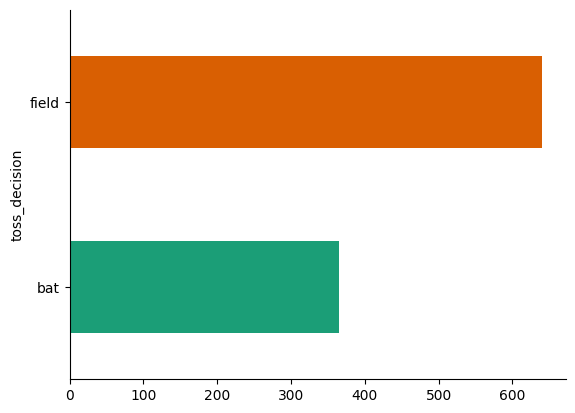

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
matches.groupby('toss_decision').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# CLUSTERING

Implementation of DREAM TEAM

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:

# Load the dataset
consolidated_dff = player_stats_df.copy()

# Adjusted weights for batting metrics
weights = {
    'runs': 0.3,
    'SR': 0.25,
    'RPI': 0.2,
    'BPD': 0.15,
    'BPB': 0.1
}

# Compute batting score for each player
consolidated_dff['batting_score'] = (
    consolidated_dff['runs'] * weights['runs'] +
    consolidated_dff['SR'] * weights['SR'] +
    consolidated_dff['RPI'] * weights['RPI'] +
    consolidated_dff['BPD'] * weights['BPD'] +
    consolidated_dff['BPB'] * weights['BPB']
)



In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(consolidated_dff[['runs', 'SR', 'RPI', 'BPD', 'BPB', 'batting_score']])

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42)
consolidated_dff['cluster'] = kmeans.fit_predict(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


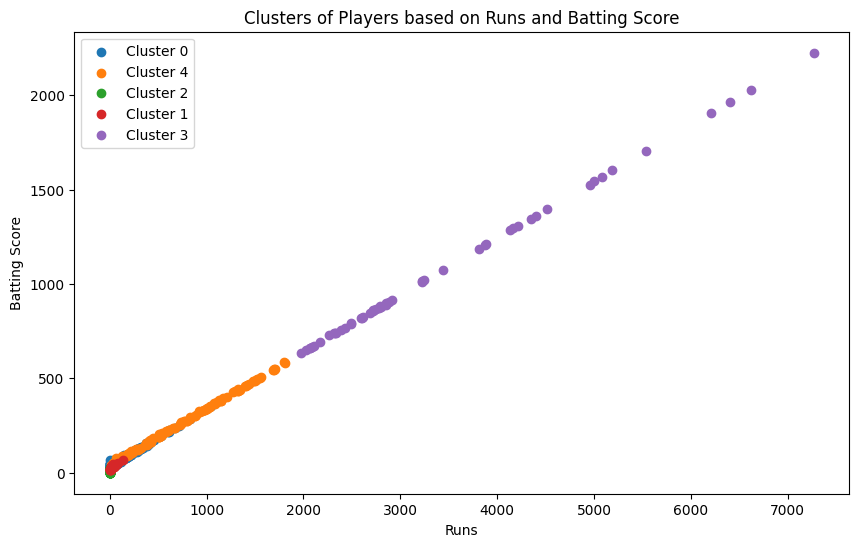

In [ ]:
plt.figure(figsize=(10, 6))
for cluster_label in consolidated_dff['cluster'].unique():
    cluster_data = consolidated_dff[consolidated_dff['cluster'] == cluster_label]
    plt.scatter(cluster_data['runs'], cluster_data['batting_score'], label=f'Cluster {cluster_label}')
plt.xlabel('Runs')
plt.ylabel('Batting Score')
plt.title('Clusters of Players based on Runs and Batting Score')
plt.legend()
plt.show()

In [ ]:
cluster_summary = consolidated_dff.groupby('cluster').agg({
    'striker': 'count',
    'runs': 'mean',
    'SR': 'mean',
    'RPI': 'mean',
    'BPD': 'mean',
    'BPB': 'mean',
    'batting_score': 'mean'
})
print(cluster_summary)

         striker         runs          SR        RPI        BPD        BPB  \
cluster                                                                      
0            282   118.283688  112.478865   8.764226  11.330884   7.877420   
1             73    26.068493   65.176121   5.025718  12.573723  23.567058   
2             79     3.050633   35.423993   1.296082   4.397890   5.765823   
3             52  3415.250000  130.073998  26.858874  24.153844   5.908038   
4            151   611.350993  123.791267  21.331268  22.447943   6.546418   

         batting_score  
cluster                 
0            67.845042  
1            29.362486  
2            11.266670  
3          1066.679155  
4           222.641202  


In [ ]:
cluster_3_players = consolidated_dff[consolidated_dff['cluster'] == 3]

# Display all players in cluster 3
print("Players in Cluster 3:")
cluster_3_players[['striker', 'runs','SR','batting_score']].sort_values(by=['batting_score'],ascending=False)

Players in Cluster 3:


,striker,runs,SR,batting_score
597,V Kohli,7273,126.729395,2224.785001
488,S Dhawan,6617,123.497574,2026.949622
138,DA Warner,6399,135.600763,1965.950451
455,RG Sharma,6213,127.055215,1904.858373
519,SK Raina,5536,132.535312,1703.787602
27,AB de Villiers,5181,148.580442,1602.247593
357,MS Dhoni,5082,131.487710,1566.784002
116,CH Gayle,4997,142.121729,1546.297097
477,RV Uthappa,4954,126.152279,1526.561178
269,KD Karthik,4517,129.352806,1395.058717


In [ ]:
#CHOICES OF PLAYERS FOR EACH POSITION BASED ON THEIR OVERALL PERFORMANCE
top_players_by_position = cluster_3_players.groupby('position').apply(lambda x: x.nlargest(2, 'batting_score')).reset_index(drop=True)
top_players_by_position[['striker','position']]

,striker,position
0,G Gambhir,1.0
1,F du Plessis,1.0
2,DA Warner,2.0
3,CH Gayle,2.0
4,V Kohli,3.0
5,S Dhawan,3.0
6,MS Dhoni,4.0
7,RV Uthappa,4.0
8,RG Sharma,5.0
9,SK Raina,5.0


For Bowlers

In [ ]:
bowler_data = bowling_stats.copy()

In [ ]:
# Adjusted weights for bowling metrics
weights = {
    'runs_conceded': 0.4,
    'wickets': 0.4,
    'economy_rate': 0.2
}

# Compute bowling score for each bowler
bowler_data['bowling_score'] = (
    bowler_data['runs_conceded'] * weights['runs_conceded'] +
    bowler_data['wickets'] * weights['wickets'] +
    bowler_data['economy_rate'] * weights['economy_rate']
)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(bowler_data[['runs_conceded', 'wickets', 'economy_rate', 'bowling_score']])

from sklearn.impute import SimpleImputer

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
scaled_features_imputed = imputer.fit_transform(scaled_features)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42)
bowler_data['cluster'] = kmeans.fit_predict(scaled_features_imputed)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


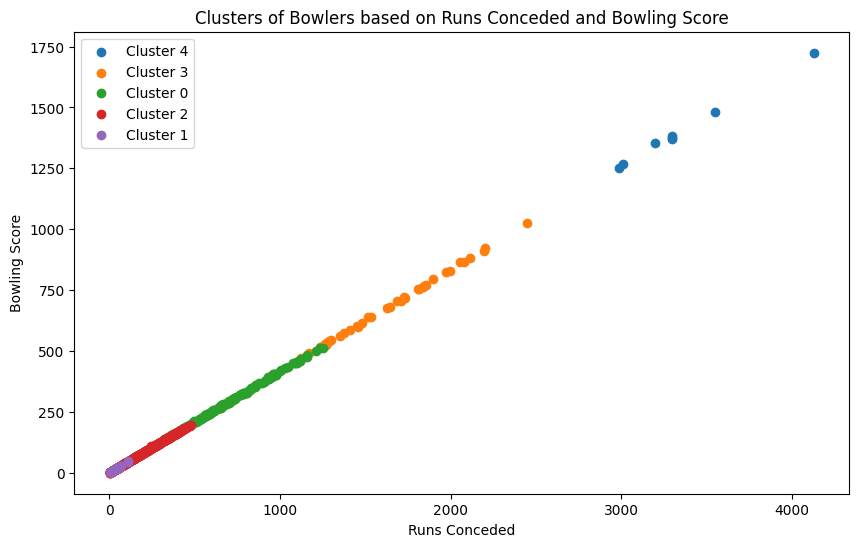

         bowler  runs_conceded     wickets  economy_rate  bowling_score
cluster                                                                
0           152     718.763158   29.256579      2.164268     299.640748
1            60      34.533333    0.416667      4.416238      14.863248
2           655     158.574046    5.506870      2.352255      66.202561
3            39    1627.410256   70.000000      2.162530     679.396609
4             8    3343.500000  157.250000      2.028995    1400.705799


In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_label in bowler_data['cluster'].unique():
    cluster_data = bowler_data[bowler_data['cluster'] == cluster_label]
    plt.scatter(cluster_data['runs_conceded'], cluster_data['bowling_score'], label=f'Cluster {cluster_label}')
plt.xlabel('Runs Conceded')
plt.ylabel('Bowling Score')
plt.title('Clusters of Bowlers based on Runs Conceded and Bowling Score')
plt.legend()
plt.show()


# Analyze the clusters
cluster_summary = bowler_data.groupby('cluster').agg({
    'bowler': 'count',
    'runs_conceded': 'mean',
    'wickets': 'mean',
    'economy_rate': 'mean',
    'bowling_score': 'mean'
})
print(cluster_summary)

In [ ]:
cluster_0_players = bowler_data[bowler_data['cluster'] == 4]
print("Players in Cluster 4:")
cluster_0_players[['bowler','wickets','bowling_score','economy_rate']].sort_values(by='bowling_score',ascending=False)

Players in Cluster 4:


,bowler,wickets,bowling_score,economy_rate
344,SP Narine,182,1724.780682,1.903412
858,B Kumar,159,1482.009825,2.049127
422,JJ Bumrah,161,1384.007097,2.035486
414,Harbhajan Singh,136,1372.787108,1.935538
53,RA Jadeja,131,1371.621904,2.109521
468,SL Malinga,188,1353.184132,1.920661
14,DJ Bravo,158,1266.034647,2.173234
845,YS Chahal,143,1251.220996,2.104980


# PRICE VALUATION

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Mining_Datasets/IPL_Data.csv')

In [ ]:
df['Type'] = df['Type'].str.strip()
# Filter data for batsmen and all-rounders
batsman_allrounder_df = df[df['Type'].isin(['Batsman', 'All-Rounder'])]

In [ ]:
relevant_columns_batsman_allrounder = ['MatchPlayed', 'RunsScored', 'BattingAVG', 'BattingS/R', 'ValueinCR']
batsman_allrounder_df = batsman_allrounder_df[relevant_columns_batsman_allrounder]

# Split data for batsmen and all-rounders into features and target
X_batsman_allrounder = batsman_allrounder_df.drop(columns=['ValueinCR'])
y_batsman_allrounder = batsman_allrounder_df['ValueinCR']

# Split data into train and test sets
X_train_batsman_allrounder, X_test_batsman_allrounder, y_train_batsman_allrounder, y_test_batsman_allrounder = train_test_split(
    X_batsman_allrounder, y_batsman_allrounder, test_size=0.2, random_state=42)
numeric_features = ['MatchPlayed', 'RunsScored', 'BattingAVG', 'BattingS/R']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])
rf_pipeline_batsman_allrounder = Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('regressor', RandomForestRegressor())])
rf_pipeline_batsman_allrounder.fit(X_train_batsman_allrounder, y_train_batsman_allrounder)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MatchPlayed', 'RunsScored',
                                                   'BattingAVG',
                                                   'BattingS/R'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
y_pred_train_batsman_allrounder = rf_pipeline_batsman_allrounder.predict(X_train_batsman_allrounder)
y_pred_test_batsman_allrounder = rf_pipeline_batsman_allrounder.predict(X_test_batsman_allrounder)
train_rmse_batsman_allrounder = mean_squared_error(y_train_batsman_allrounder, y_pred_train_batsman_allrounder, squared=False)
test_rmse_batsman_allrounder = mean_squared_error(y_test_batsman_allrounder, y_pred_test_batsman_allrounder, squared=False)

print("Batsman & All-Rounder Model Train RMSE:", train_rmse_batsman_allrounder)
print("Batsman & All-Rounder Model Test RMSE:", test_rmse_batsman_allrounder)

Batsman & All-Rounder Model Train RMSE: 1.685943714007677
Batsman & All-Rounder Model Test RMSE: 3.276309251810557


In [ ]:
new_data = pd.DataFrame({
    'MatchPlayed': [100],
    'RunsScored': [2800],
    'BattingAVG': [95],
    'BattingS/R': [145]
})
X_new_data = new_data
predicted_valuation = rf_pipeline_batsman_allrounder.predict(X_new_data)
print("Predicted Valuation for New Batsman/AllRounder:", predicted_valuation)

Predicted Valuation for New Batsman/AllRounder: [11.6565]


In [ ]:
bowler_df = df[df['Type'] == 'Bowler']
relevant_columns_bowler = ['MatchPlayed', 'Wickets', 'BowlingAVG', 'EconomyRate', 'ValueinCR']
bowler_df = bowler_df[relevant_columns_bowler]
X_bowler = bowler_df.drop(columns=['ValueinCR'])
y_bowler = bowler_df['ValueinCR']
X_train_bowler, X_test_bowler, y_train_bowler, y_test_bowler = train_test_split(
    X_bowler, y_bowler, test_size=0.2, random_state=42)
numeric_features = ['MatchPlayed', 'Wickets', 'BowlingAVG', 'EconomyRate']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])
rf_pipeline_bowler = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor())])
rf_pipeline_bowler.fit(X_train_bowler, y_train_bowler)
y_pred_train_bowler = rf_pipeline_bowler.predict(X_train_bowler)
y_pred_test_bowler = rf_pipeline_bowler.predict(X_test_bowler)
train_rmse_bowler = mean_squared_error(y_train_bowler, y_pred_train_bowler, squared=False)
test_rmse_bowler = mean_squared_error(y_test_bowler, y_pred_test_bowler, squared=False)

print("Bowler Model Train RMSE:", train_rmse_bowler)
print("Bowler Model Test RMSE:", test_rmse_bowler)

Bowler Model Train RMSE: 1.574371705005584
Bowler Model Test RMSE: 2.4951973494155215


In [ ]:
new_data_bowler = pd.DataFrame({
    'MatchPlayed': [50],
    'Wickets': [80],
    'BowlingAVG': [15],
    'EconomyRate': [1.5]
})
predicted_valuation_bowler = rf_pipeline_bowler.predict(new_data_bowler)
print("Predicted Valuation for New Bowler Data:", predicted_valuation_bowler)

Predicted Valuation for New Bowler Data: [10.502]


In [ ]:
from sklearn.metrics import r2_score

a1 = r2_score(y_test_bowler, y_pred_test_bowler)
a2 = r2_score(y_test_batsman_allrounder, y_pred_test_batsman_allrounder)
print(a1,a2)

0.2515936684989962 0.21875476854455111


#Impact Player

In [ ]:
# Merge the two dataframes on the 'player' column
merged_df = pd.merge(consolidated_dff, bowler_data, how='inner', left_on='striker', right_on='bowler')

# Drop the duplicate 'player' column (resulting from the merge)
merged_df.drop('bowler', axis=1, inplace=True)

In [ ]:
# Find the cluster with the highest average batting score
average_batting_scores = merged_df.groupby('striker')['batting_score'].mean()
cluster_with_highest_avg_score = average_batting_scores.idxmax()

# Find the player with the highest batting score in the cluster with the highest average batting score
impact_player = consolidated_dff[consolidated_dff['striker'] == cluster_with_highest_avg_score].nlargest(1, 'batting_score')['striker'].values[0]

print("Impact Player:", impact_player)

Impact Player: V Kohli


In [ ]:
# Merge the two dataframes on the 'striker' column from merged_df and 'Name' column from df
final_merged_df = pd.merge(merged_df, df, how='inner', left_on='striker', right_on='Name')

# Drop the duplicate 'striker' column (resulting from the merge)
final_merged_df.drop('Name', axis=1, inplace=True)

# Now 'final_merged_df' contains both batting and bowling information along with additional player details
final_merged_df.columns

Index(['striker', 'innings', 'runs', 'balls_x', 'dismissals', 'dots', 'ones',
       'twos', 'threes', 'fours', 'sixes', 'SR', 'RPI', 'BPD', 'BPB',
       'position', 'batting_score', 'cluster_x', 'balls_y', 'runs_conceded',
       'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty_runs',
       'total_runs', 'wickets', 'overs', 'economy_rate', 'strike_rate',
       'bowling_score', 'cluster_y', 'Team', 'Url', 'Type', 'ValueinCR',
       'Full Name', 'Born', 'Age', 'National Side', 'Batting Style', 'Bowling',
       'Sport', 'MatchPlayed', 'InningsBatted', 'NotOuts', 'RunsScored',
       'HighestInnScore', '100s', '50s', '4s', '6s', 'BattingAVG',
       'BattingS/R', 'CatchesTaken', 'StumpingsMade', 'Ducks', 'R/O',
       'InningsBowled', 'Overs', 'Maidens', 'RunsConceded', 'Wickets', 'Best',
       '3s', '5s', 'BowlingAVG', 'EconomyRate', 'S/R', 'Mtc'],
      dtype='object')

In [ ]:
# Assuming 'Performance' is a combination of batting and bowling scores
final_merged_df['Performance'] = final_merged_df['batting_score'] + final_merged_df['bowling_score']

# Find the median value of 'ValueinCR'
median_value_in_cr = final_merged_df['ValueinCR'].median()

# Identify overestimated players (players with 'ValueinCR' higher than the median but lower performance)
overestimated_players = final_merged_df[final_merged_df['ValueinCR'] > median_value_in_cr]
overestimated_players = overestimated_players[overestimated_players['Performance'] < overestimated_players['Performance'].median()]

# Print overestimated players
print(overestimated_players)


              striker  innings  runs  balls_x  dismissals  dots  ones  twos  \
0         Abdul Samad       27   397      295          22   112   113    23   
5          Avesh Khan        7    31       20           1    10     5     0   
6          Avesh Khan        7    31       20           1    10     5     0   
7          Avesh Khan        7    31       20           1    10     5     0   
12      Harpreet Brar       17   158      142          10    61    54     9   
17       Kartik Tyagi        6    13       16           4     7     7     1   
18       Kartik Tyagi        6    13       16           4     7     7     1   
27     Mohammed Shami       23    74       82          13    41    28     5   
29     Mohammed Siraj       19    97      113           9    61    35     5   
40       Ravi Bishnoi       11    28       46           5    28    13     2   
49        T Natarajan        2     3        5           0     2     3     0   
53  Washington Sundar       37   378      340       

In [ ]:
# Calculate the overestimation for each player
final_merged_df['Overestimation'] = final_merged_df['ValueinCR'] - final_merged_df['Performance']

# Find the player with the highest overestimation
most_overestimated_player = final_merged_df.loc[final_merged_df['Overestimation'].idxmax()]

# Print the most overestimated player
print(most_overestimated_player)


striker           KM Asif
innings                 1
runs                    0
balls_x                 2
dismissals              1
                   ...   
EconomyRate         11.38
S/R                 12.25
Mtc                   3.0
Performance          38.7
Overestimation      -38.5
Name: 15, Length: 73, dtype: object


In [ ]:
# Calculate the underestimation for each player
final_merged_df['Underestimation'] = final_merged_df['Performance'] - final_merged_df['ValueinCR']

# Find the player with the highest underestimation
most_underestimated_player = final_merged_df.loc[final_merged_df['Underestimation'].idxmax()]

# Print the most underestimated player
print(most_underestimated_player)


striker            Rashid Khan
innings                     50
runs                       443
balls_x                    280
dismissals                  32
                      ...     
S/R                      19.48
Mtc                       76.0
Performance         973.547373
Overestimation     -958.547373
Underestimation     958.547373
Name: 37, Length: 74, dtype: object
